In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import humanlikehearing
import os

## Result Plotting

Below you can find an example of how you can visualise the results from one of your experiments. 


In [52]:
# First lets run a dummy experiment to obtain a results file.
asr_system = humanlikehearing.asrsystem.DummyASR('')
dataset = humanlikehearing.dataset.DummyDataSet('.')
bandpass_test = humanlikehearing.testbattery.BandpassTest('results', sentences_per_condition=1)
bandpass_test.run(asr_system, dataset)

# Load the results file
result_folder = bandpass_test._get_result_folder('standard')
results = pd.read_pickle(os.path.join(result_folder, 'results.pk1'))

The results file will have a multi index, which indicates the condition parameters. In this case, it contains the sentence id and the threshold used in the experiment for every row in the results file:

In [53]:
results.index

MultiIndex([(0,  nan),
            (0, 42.0),
            (0, 41.0),
            (0, 40.0),
            (0, 39.0),
            (0, 38.0),
            (0, 37.0),
            (0, 36.0),
            (0, 35.0),
            (0, 34.0),
            (0, 33.0),
            (0, 32.0),
            (0, 31.0),
            (0, 30.0),
            (0, 29.0),
            (0, 28.0),
            (0, 27.0),
            (0, 26.0),
            (0, 25.0),
            (0, 24.0),
            (0, 23.0),
            (0, 22.0),
            (0, 21.0),
            (0, 20.0),
            (0, 19.0),
            (0, 18.0),
            (0, 17.0),
            (0, 16.0),
            (0, 15.0),
            (0, 14.0),
            (0, 13.0),
            (0, 12.0),
            (0, 11.0),
            (0, 10.0),
            (0,  9.0),
            (0,  8.0),
            (0,  7.0),
            (0,  6.0),
            (0,  5.0),
            (0,  4.0)],
           names=['sentence_id', 'bandpass_width_semitone'])

The outcomes of the experiments are stored in columns, the main one of interest is usually 'keyword accuracy':

In [54]:
print(results.columns)
print(results['keyword_accuracy'])

Index(['keyword_accuracy', 'predicted_transcription', 'transcription'], dtype='object')
sentence_id  bandpass_width_semitone
0            NaN                        1.0
             42                         1.0
             41                         1.0
             40                         1.0
             39                         1.0
             38                         1.0
             37                         1.0
             36                         1.0
             35                         1.0
             34                         1.0
             33                         1.0
             32                         1.0
             31                         1.0
             30                         1.0
             29                         1.0
             28                         1.0
             27                         1.0
             26                         1.0
             25                         1.0
             24                        

Pandas offers many ways of accessing a specific set of parameters when using a MultiIndex. One easy way to obtain for example all items with a threshold higher than 0.5 is as follows:

In [57]:
subset_results = results[results.index.get_level_values('bandpass_width_semitone') > 10]

To plot the results, simply select the keyword accuracy and plot. In this case, the output is a horizontal line since our DummyASR always predicts 'hello world' and the target transcription of the DummyDataSet is always 'hello world'. 

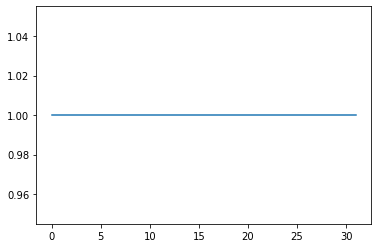

In [58]:
plt.plot(subset_results['keyword_accuracy'].values)

## Speech Reception Threshold Analysis

To run the SRT analysis, first install psignifit following the installation instructions of that package:

https://github.com/wichmann-lab/python-psignifit/wiki/Install

Once installed, run a quick dummy experiment to obtain some SRT values:

In [ ]:
pip install https://github.com/wichmann-lab/python-psignifit/zipball/master

In [71]:
asr_system = humanlikehearing.asrsystem.DummyASR('')
dataset = humanlikehearing.asrsystem.DummyDataSet('.')

test_params = {
    'cutoff_values': [0],
    'region_width': 6,
    'vocoder_types': ['retain_tfs_below_cutoff'],
}

tfs_test = humanlikehearing.testbattery.TemporalFineStructureTest(
    'results', test_parameters=test_params, sentences_per_condition=1)           
tfs_test.run(asr_system, dataset)

In [72]:
result_folder = tfs_test._get_result_folder('standard')
results = pd.read_pickle(os.path.join(result_folder, 'results.pk1'))

Let's select a single condition:

In [110]:
subset_results = results[(
        (results.index.get_level_values('noise_type') == "white_noise") &
        (results.index.get_level_values('vocoder_type') == "retain_tfs_below_cutoff") & 
        (results.index.get_level_values('cutoff_values') == "0") 
)]

We now need to select the SNRs and the keyword_accuracy to compute the SRTs:

In [115]:
srts = subset_results.index.get_level_values('SNR').values
accuracy = subset_results['keyword_accuracy'].values

And now we can fit the psychometric function to obtain an SRT (speech reception threshold). Note that you will likely get some warnings here since we are trying to fit a horizontal line! If you use real data these should disappear. 

In [120]:
import psignifit

def fit_psychometric_function(
    snrs, accuracy, sigmoid_name='logistic', 
    average_keywords_per_sentence=5, 
    srt_threshold=0.5, fast=False):

    # psignifit assumes 'yes' or 'no' answers
    accuracy *= average_keywords_per_sentence
    nr_trials = np.ones(len(accuracy))*average_keywords_per_sentence
    data = np.concatenate([snrs, accuracy, nr_trials]).reshape(3, -1).T
    options = {
        'sigmoidName': sigmoid_name,
        'confP': [], #[0.95],
        'threshPC': srt_threshold
    }
    
    if fast:
        fit = psignifit.psignifitFast
    else:
        fit = psignifit.psignifit
    
    result = fit(data, options) #psignifit(data, options)
    return result['Fit'][0]

fit_psychometric_function(srts, accuracy)

(array([], dtype=int64),)


/Users/lotteweerts/anaconda/envs/humanhearing/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/lotteweerts/anaconda/envs/humanhearing/lib/python3.6/site-packages/psignifit/likelihood.py:127: RuntimeWarning: invalid value encountered in subtract
  p = p -sp.gammaln(n+v) - sp.gammaln(a) - sp.gammaln(b)
/Users/lotteweerts/anaconda/envs/humanhearing/lib/python3.6/site-packages/psignifit/likelihood.py:222: RuntimeWarning: divide by zero encountered in log
  prior = np.log(temp)
/Users/lotteweerts/anaconda/envs/humanhearing/lib/python3.6/site-packages/psignifit/likelihood.py:121: RuntimeWarning: divide by zero encountered in log
  p = p + k * np.log(psi) + (n-k)*np.log(

-15.783619633274157